# Optimize with ShareParameters

In [1]:
from desc.examples import get
from desc.geometry import FourierRZToroidalSurface
from desc.magnetic_fields import FourierCurrentPotentialField
import numpy as np
from desc.plotting import *
eq1 = get("ESTELL")
eq2 = eq1.copy()
eq2.change_resolution(M=1,N=1)
eq2.change_resolution(L=8,M=8, N=4, L_grid=14, M_grid=14, N_grid=8)
eq2.surface = eq2.get_surface_at(rho=1.0)
eq2.solve(verbose=1);

DESC version 0.12.3+53.gd138a4990.dirty,using JAX backend, jax version=0.4.31, jaxlib version=0.4.30, dtype=float64
Using device: CPU, with 3.53 GB available memory


/Users/dpanici/Research/DESC/desc/utils.py:555: UserWarning: Reducing radial (L) resolution can make plasma boundary inconsistent. Recommend calling `eq.surface = eq.get_surface_at(rho=1.0)`
  warnings.warn(colored(msg, "yellow"), err)


Building objective: force
Precomputing transforms
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed sheet current
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Number of parameters: 452
Number of objectives: 2176

Starting optimization
Using method: lsq-exact
         Current function value: 6.866e-11
         Total delta_x: 1.730e-01
         Iterations: 100
         Function evaluations: 122
         Jacobian evaluations: 101
                                                                 Start  -->   End
Total (sum of squares):                                      1.858e+02  -->   6.866e-11, 
Maximum absolute Force error:                                1.155e+08  -->   1.156e+01 (N)
Minimum absolute Force

(<Figure size 432.324x432.324 with 1 Axes>,
 <Axes: xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>)

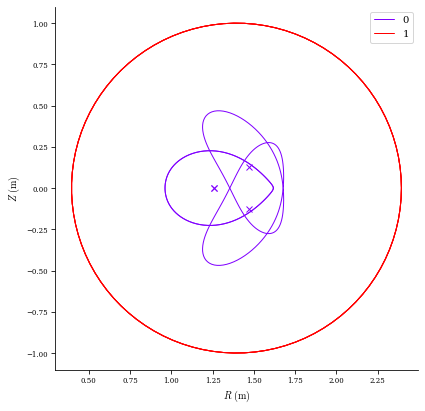

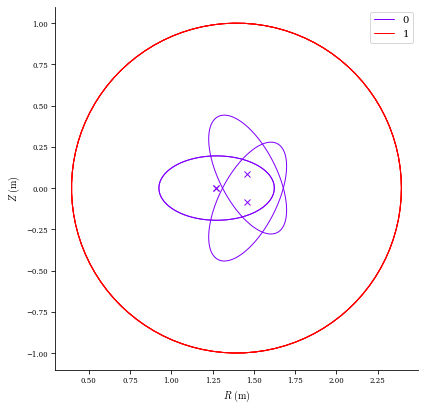

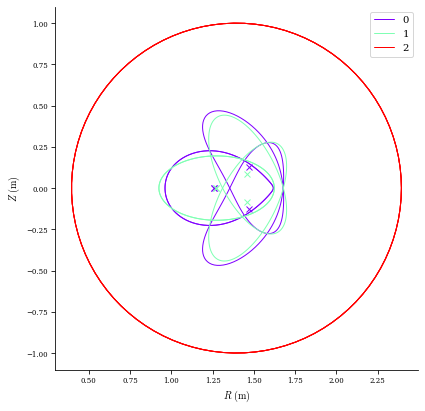

In [2]:
from scipy.constants import mu_0
necessary_G_for_eq1 = eq1.compute("G")["G"][-1] / mu_0 * 2*np.pi
necessary_G_for_eq2 = eq2.compute("G")["G"][-1] / mu_0 * 2*np.pi

R0 = eq1.compute("R0")["R0"]
a = 1
surf1 = FourierRZToroidalSurface(R_lmn =  [R0,a], Z_lmn = [-a],
                                modes_R = [[0,0],[1,0]], modes_Z = [[-1,0]],NFP=eq1.NFP)
surf1.change_resolution(M=2,N=2)
surf1 = FourierCurrentPotentialField.from_surface(surf1,M_Phi=6,N_Phi=6,sym_Phi=False, I=0, G=necessary_G_for_eq1)
surf2 = surf1.copy()
surf2.G = necessary_G_for_eq2
plot_boundaries([eq1, surf1],phi=np.linspace(0,2*np.pi/eq1.NFP,4))
plot_boundaries([eq2, surf1],phi=np.linspace(0,2*np.pi/eq1.NFP,4))

plot_boundaries([eq1,eq2, surf1],phi=np.linspace(0,2*np.pi/eq1.NFP,4))

In [4]:
## setup opt problem
# use QuadraticFlux as eq's are fixed and want fields to change
# use ShareParameters to keep surface geoms constant equal to eachother as they vary with surface current to reduce Bn
# first, keep surfs fixed too and just get regcoil-like solutions for each
from desc.objectives import QuadraticFlux, PlasmaVesselDistance, ShareParameters, FixParameters, ObjectiveFunction
from desc.grid import LinearGrid
from desc.optimize import Optimizer
surf_grid = LinearGrid(M=20,N=20,NFP=surf1.NFP)
eval_grid =  LinearGrid(M=20,N=20,NFP=surf1.NFP)
obj = ObjectiveFunction((QuadraticFlux(eq1,surf1,field_grid=surf_grid,eval_grid=eval_grid,vacuum=True,name="Bn error  eq1"),
                         QuadraticFlux(eq2,surf2,field_grid=surf_grid,eval_grid=eval_grid,vacuum=True,name="Bn error  eq2")))
constraints = (#ShareParameters([surf1,surf2],params={"R_lmn":True, "Z_lmn":True}), # make the 2 surfaces have the same geometry, dont need bc geom is fixed here
               FixParameters(surf1,{"I":True,"G":True,"R_lmn":True, "Z_lmn":True}),FixParameters(surf2,{"I":True,"G":True,"R_lmn":True, "Z_lmn":True})) # fix the secular parts as well
                        
opt = Optimizer("lsq-exact")

(surf1, surf2), _ = opt.optimize([surf1, surf2], objective=obj, constraints=constraints,verbose=3,maxiter=2,ftol=1e-8,
                                options={"initial_trust_radius":np.inf})


Building objective: Bn error  eq1
Precomputing transforms
Timer: Precomputing transforms = 1.56 sec
Building objective: Bn error  eq2
Precomputing transforms
Timer: Precomputing transforms = 707 ms
Timer: Objective build = 2.31 sec
Building objective: fixed parameters
Building objective: fixed parameters
Timer: Objective build = 141 ms
Timer: Linear constraint projection build = 646 ms
Number of parameters: 338
Number of objectives: 3362
Timer: Initializing the optimization = 3.14 sec

Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          4.745e+01                                    5.848e-05   


/Users/dpanici/Research/DESC/desc/optimize/least_squares.py:346: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= tr_old / trust_radius


       1              2          7.626e-03      4.744e+01      1.224e+07      2.997e-10   
`gtol` condition satisfied.
         Current function value: 7.626e-03
         Total delta_x: 1.224e+07
         Iterations: 1
         Function evaluations: 2
         Jacobian evaluations: 2
Timer: Solution time = 41.1 sec
Timer: Avg time per step = 20.5 sec
                                                                 Start  -->   End
Total (sum of squares):                                      4.745e+01  -->   7.626e-03, 
Maximum absolute Boundary normal field error:                1.624e-01  -->   6.054e-03 (T m^2)
Minimum absolute Boundary normal field error:                2.240e-17  -->   6.563e-07 (T m^2)
Average absolute Boundary normal field error:                6.141e-02  -->   9.009e-04 (T m^2)
Maximum absolute Boundary normal field error:                3.817e-01  -->   1.423e-02 (normalized)
Minimum absolute Boundary normal field error:                5.265e-17  -->   1.543e-0

Text(0.5, 1.0, 'Phi surf2')

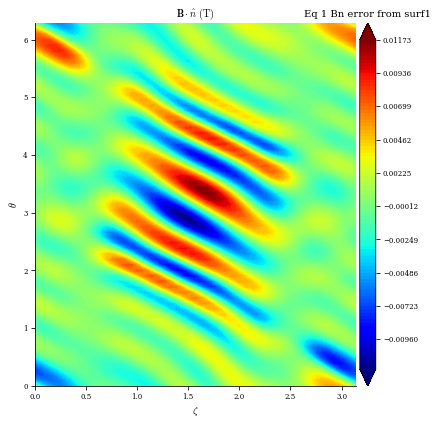

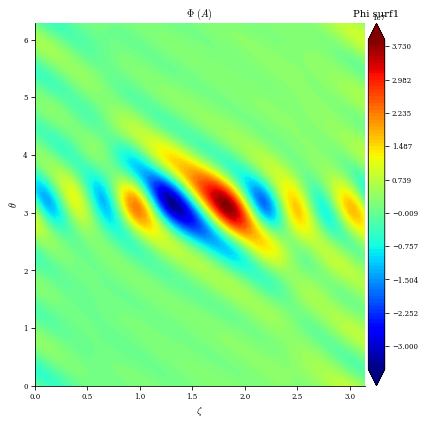

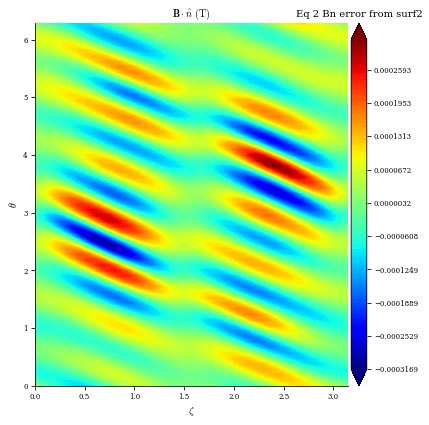

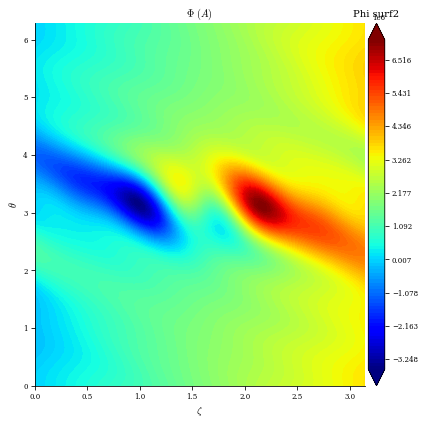

In [6]:
import matplotlib.pyplot as plt
# look at Phi and Bn
denser_source_grid = LinearGrid(M=40,N=40,NFP=eq1.NFP)
plot_2d(eq1,"B*n",field=surf1, field_grid=denser_source_grid)
plt.title("Eq 1 Bn error from surf1")

plot_2d(surf1, "Phi")
plt.title("Phi surf1")


plot_2d(eq2,"B*n",field=surf2, field_grid=denser_source_grid)
plt.title("Eq 2 Bn error from surf2")
plot_2d(surf2, "Phi")
plt.title("Phi surf2")



In [7]:
## setup opt problem
# use QuadraticFlux as eq's are fixed and want fields to change
# use ShareParameters to keep surface geoms constant equal
# to eachother as they vary with surface current to reduce Bn
surf_grid = LinearGrid(M=20,N=20,NFP=surf1.NFP)
eval_grid =  LinearGrid(M=20,N=20,NFP=surf1.NFP)
obj = ObjectiveFunction((QuadraticFlux(eq1,surf1,field_grid=surf_grid,eval_grid=eval_grid,vacuum=True,name="Bn error  eq1"), QuadraticFlux(eq2,surf2,field_grid=surf_grid,eval_grid=eval_grid,vacuum=True,name="Bn error  eq2"),
                        PlasmaVesselDistance(eq1,surf1,bounds=(0.25,np.inf),
                                             surface_grid=surf_grid,eq_fixed=True,name="distance error  eq1"), 
                         PlasmaVesselDistance(eq2,surf2,bounds=(0.25,np.inf),
                                              surface_grid=surf_grid,eq_fixed=True,name="distance error  eq2")
                        )
                       )
constraints = (ShareParameters([surf1,surf2],params={"R_lmn":True, "Z_lmn":True}), # make the 2 surfaces have the same geometry
               FixParameters(surf1,{"I":True,"G":True}),FixParameters(surf2,{"I":True,"G":True})) # fix the secular parts as well
                        
opt = Optimizer("lsq-exact")

(surf1, surf2), _ = opt.optimize([surf1, surf2], objective=obj, constraints=constraints,verbose=3,maxiter=10,ftol=1e-8)


Building objective: Bn error  eq1
Precomputing transforms
Timer: Precomputing transforms = 45.7 ms
Building objective: Bn error  eq2
Precomputing transforms
Timer: Precomputing transforms = 36.1 ms
Building objective: distance error  eq1
Precomputing transforms
Timer: Precomputing transforms = 305 ms
Building objective: distance error  eq2
Precomputing transforms
Timer: Precomputing transforms = 238 ms
Timer: Objective build = 655 ms
Building objective: fixed parameters
Building objective: fixed parameters
Building objective: fixed parameters
Timer: Objective build = 11.8 ms
Timer: Linear constraint projection build = 638 ms
Number of parameters: 363
Number of objectives: 6724
Timer: Initializing the optimization = 1.36 sec

Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          7.626e-03                                    1.613e-02   
       1              6          6.76

(<Figure size 432.324x432.324 with 1 Axes>,
 <Axes: xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>)

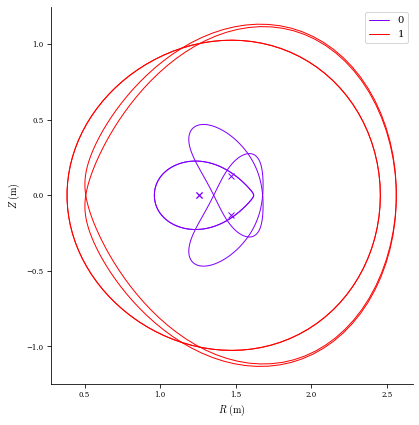

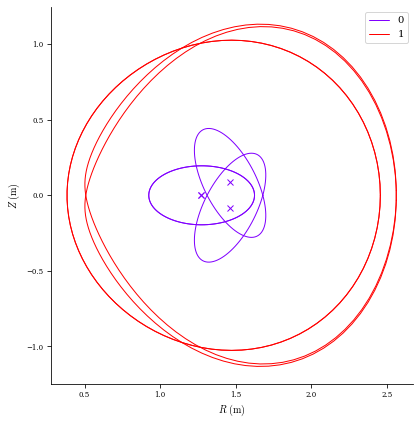

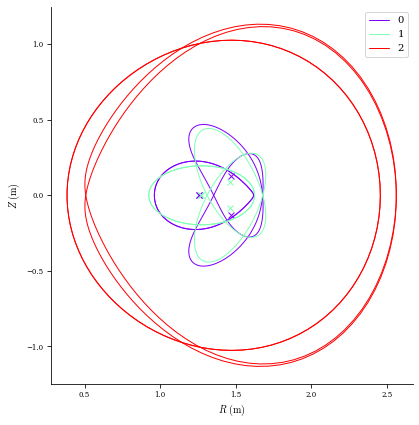

In [8]:
plot_boundaries([eq1, surf1],phi=np.linspace(0,2*np.pi/eq1.NFP,4))
plot_boundaries([eq2, surf2],phi=np.linspace(0,2*np.pi/eq1.NFP,4))

plot_boundaries([eq1,eq2, surf1],phi=np.linspace(0,2*np.pi/eq1.NFP,4))

Text(0.5, 1.0, 'Phi surf2')

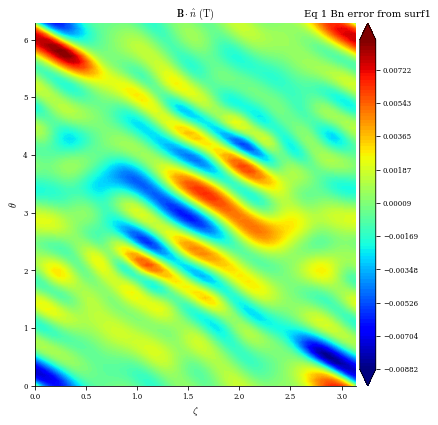

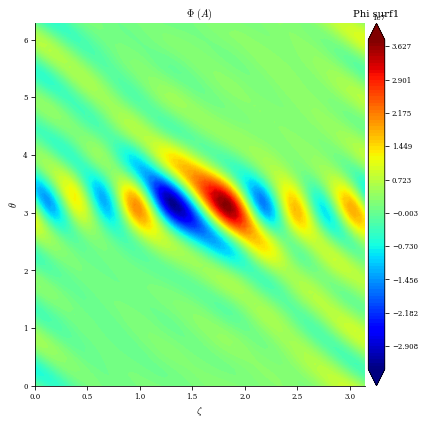

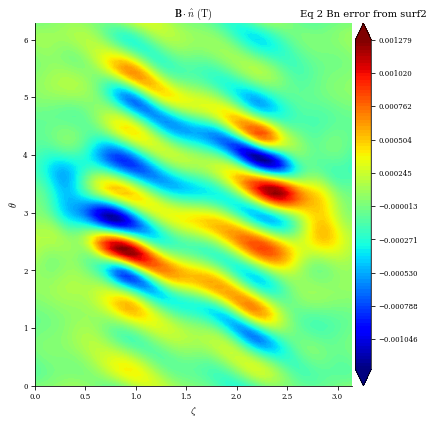

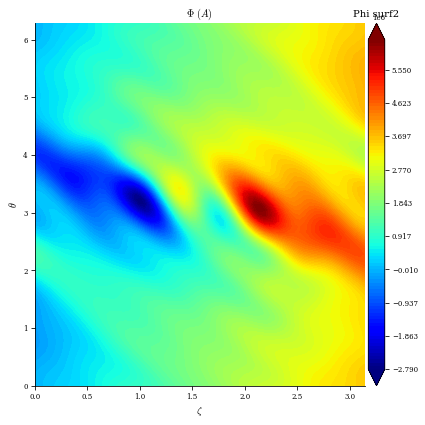

In [9]:
# look at Phi and Bn
denser_source_grid = LinearGrid(M=40,N=40,NFP=eq1.NFP)
plot_2d(eq1,"B*n",field=surf1, field_grid=denser_source_grid)
plt.title("Eq 1 Bn error from surf1")

plot_2d(surf1, "Phi")
plt.title("Phi surf1")


plot_2d(eq2,"B*n",field=surf2, field_grid=denser_source_grid)
plt.title("Eq 2 Bn error from surf2")
plot_2d(surf2, "Phi")
plt.title("Phi surf2")



In [10]:
from desc.plotting import poincare_plot

(<Figure size 864.648x720.54 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

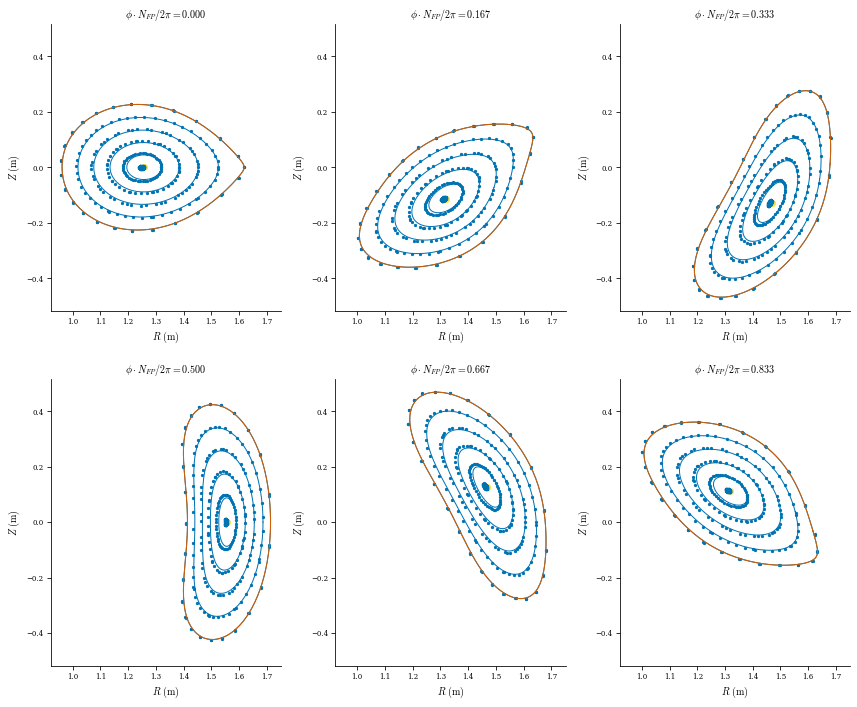

In [11]:
grid = LinearGrid(L=5,M=0,N=0)
R0 = eq1.compute("R",grid=grid)["R"]
Z0 = np.zeros_like(R0)
fig1,ax1 = plot_surfaces(eq1,theta=0,rho=grid.nodes[:,0])
poincare_plot(surf1,R0,Z0,ntransit=50,NFP=eq1.NFP,ax=ax1)


(<Figure size 864.648x720.54 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

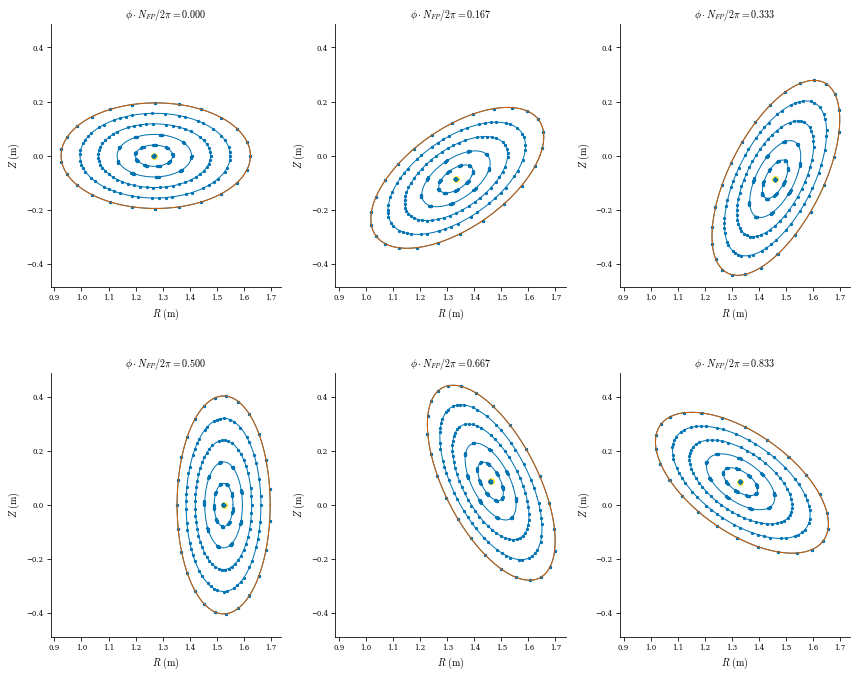

In [12]:
grid = LinearGrid(L=5,M=0,N=0)
R0 = eq2.compute("R",grid=grid)["R"]
Z0 = np.zeros_like(R0)
fig2,ax2 = plot_surfaces(eq2,theta=0,rho=grid.nodes[:,0])
poincare_plot(surf2,R0,Z0,ntransit=50,NFP=eq2.NFP,ax=ax2)
